In [84]:
import math
import logging
import time
import random
import sys
import argparse
import torch
import pandas as pd
import numpy as np

from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from module import TGAN
from graph import NeighborFinder
from utils import EarlyStopMonitor, RandEdgeSampler
from scipy.stats import spearmanr
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, MaxNLocator
from scipy.stats import kendalltau,pearsonr,weightedtau
from collections import defaultdict

In [102]:

with open('./saved_att/wikifull_no_uni_20ep.json', 'r') as f:
    no_uni_20_ep_wiki = json.load(f)
with open('./saved_att/wikifull_uni_20ep.json', 'r') as f:
    uni_20_ep_wiki = json.load(f)
with open('./saved_att/wikifull_no_uni_20ep_50ngh.json', 'r') as f:
    no_uni_20_ep_wiki_50nghs = json.load(f)
with open('./saved_att/wikifull_no_uni_20ep_10ngh.json', 'r') as f:
    no_uni_20_ep_wiki_10nghs = json.load(f)
with open('./saved_att/wikifull_no_uni_20ep_1head.json', 'r') as f:
    no_uni_20_ep_wiki_1head = json.load(f)
with open('./saved_att/wikifull_no_uni_20ep_4head.json', 'r') as f:
    no_uni_20_ep_wiki_4head = json.load(f)
with open('./saved_att/r17full_uni_20ep.json', 'r') as f:
    uni_rg17 = json.load(f)
with open('./saved_att/r17full_no_uni_20ep.json', 'r') as f:
    no_uni_rg17 = json.load(f)

In [103]:
wiki_df = pd.read_csv('./processed/ml_wikipedia.csv')
twitter_df=pd.read_csv('./processed/ml_rg17_with_labels.csv')

In [104]:
def ngh_to_weight(src_group,remove_0):
    ngh_to_weights = defaultdict(list)
    for item in src_group:
        weights_lists = item['weights']  # List of two weight lists
        ngh_list = item['ngh']
        for i, ngh in enumerate(ngh_list):
                
            for weight_list in weights_lists:
                ngh_to_weights[ngh].append(weight_list[i])
    if remove_0:
        if 0 in ngh_to_weights.keys():
            del ngh_to_weights[0]
        
    return ngh_to_weights

In [105]:
def get_corr(src_group,corr,remove_0,g_df,src_idx):
    src_ts=g_df['ts'][src_idx]
    ngh_to_weights=ngh_to_weight(src_group,remove_0)
    
    ngh_avg_weights = {ngh: sum(w_list) / len(w_list) for ngh, w_list in ngh_to_weights.items()}
    ngh_ids = list(ngh_avg_weights.keys())
    ts=[g_df['ts'][i]-src_ts for i in ngh_ids]
    avg_weights = list(ngh_avg_weights.values())
    if len(ts)<2:
        return 0
    avg_weights = list(ngh_avg_weights.values())

    corr, pval = corr(ngh_ids, avg_weights)
    
    return corr

In [106]:
def plot_corr(data,corr,num_inst,group_avg,remove_0=True,min_nghs=20,moveing_avg=True,g_df=g_df):
    size=g_df.shape[0]-1
    grouped_by_s = defaultdict(list)
    for entry in data:
        grouped_by_s[entry['s']].append(entry)
    corr_list=[]
    for i in range(num_inst):
        corr_list.append(get_corr(grouped_by_s[i],corr,remove_0,g_df=g_df,src_idx=size+i-num_inst))
        
    avg_corr_list = []
    ngh_to_weight_lst=[]
    for i in range(num_inst):
        ngh_to_weight_lst.append(ngh_to_weight(grouped_by_s[i],remove_0))
    num_nghs=[len(i.keys())for i in ngh_to_weight_lst]
    if moveing_avg==False:
        for i in range(0, len(corr_list), group_avg):
            block = corr_list[i:i+group_avg]
            block_nghs=num_nghs[i:i+group_avg]
            block = [block[x] for x in range(len(block)) if block_nghs[x]>=min_nghs]
            if block:
                avg_corr_list.append(sum(block) / len(block))
            else:
                avg_corr_list.append(np.nan)  # Keep NaN if all values are NaN
    else:
        for i in range(num_inst):
            # Define window range
            start = max(0, i - group_avg)
            end = min(num_inst, i + group_avg + 1)
            
            # Get values within window
            window_corrs = corr_list[start:end]
            window_nghs = num_nghs[start:end]
            
            # Filter by min_nghs
            filtered_corrs = [window_corrs[j] for j in range(len(window_corrs)) if window_nghs[j] >= min_nghs]
            
            # Average if valid data exists
            if filtered_corrs:
                avg_corr_list.append(sum(filtered_corrs) / len(filtered_corrs))
            else:
                avg_corr_list.append(np.nan)
    return(avg_corr_list)

In [107]:
def tsplot(g_df,num_inst,group_avg):
    timestamps=g_df['ts'][-num_inst:].to_list()
    time_for_edges=[]
    for i in range(num_inst):
        # Define window range
        start = max(0, i - group_avg)
        end = min(num_inst-1, i + group_avg + 1)
        time_for_edges.append((timestamps[end]-timestamps[start])/(end-start))
        
    return time_for_edges   
        
    

In [35]:
midnight_calc(wiki_df,11713)

[4036, 8062]

In [108]:
def midnight_calc(g_df,num_inst):
    day_in_sec=86400
    Turned=False
    timestamps=g_df['ts'][-num_inst:].to_list()
    midnight=0
    while timestamps[0]> midnight:
        midnight += day_in_sec
    indexes=[]
    for i in range(len(timestamps)):
        while timestamps[i]> midnight:
            midnight += day_in_sec
            Turned=True
        if Turned:
            indexes.append(i)
        Turned=False
    return indexes
    

In [109]:
no_uni_spear=plot_corr(no_uni_20_ep_wiki,spearmanr,11713,500)
no_uni_kend=plot_corr(no_uni_20_ep_wiki,kendalltau,11713,500)
no_uni_pearson=plot_corr(no_uni_20_ep_wiki,pearsonr,11713,500)
no_uni_w_kend=plot_corr(no_uni_20_ep_wiki,weightedtau,11713,500)
uni_spear=plot_corr(uni_20_ep_wiki,spearmanr,11713,500)
uni_kend=plot_corr(uni_20_ep_wiki,kendalltau,11713,500)
uni_pearson=plot_corr(uni_20_ep_wiki,pearsonr,11713,500)
uni_w_kend=plot_corr(uni_20_ep_wiki,weightedtau,11713,500)
no_uni_spear_50nghs=plot_corr(no_uni_20_ep_wiki_50nghs,spearmanr,11713,500)
no_uni_kend_50nghs=plot_corr(no_uni_20_ep_wiki_50nghs,kendalltau,11713,500)
no_uni_pearson_50nghs=plot_corr(no_uni_20_ep_wiki_50nghs,pearsonr,11713,500)
no_uni_w_kend_50nghs=plot_corr(no_uni_20_ep_wiki_50nghs,weightedtau,11713,500)
no_uni_spear_10nghs=plot_corr(no_uni_20_ep_wiki_10nghs,spearmanr,11713,500,min_nghs=10)
no_uni_kend_10nghs=plot_corr(no_uni_20_ep_wiki_10nghs,kendalltau,11713,500,min_nghs=10)
no_uni_pearson_10nghs=plot_corr(no_uni_20_ep_wiki_10nghs,pearsonr,11713,500,min_nghs=10)
no_uni_w_kend_10nghs=plot_corr(no_uni_20_ep_wiki_10nghs,weightedtau,11713,500,min_nghs=10)
no_uni_spear_4head=plot_corr(no_uni_20_ep_wiki_4head,spearmanr,11713,500)
no_uni_kend_4head=plot_corr(no_uni_20_ep_wiki_4head,kendalltau,11713,500)
no_uni_pearson_4head=plot_corr(no_uni_20_ep_wiki_4head,pearsonr,11713,500)
no_uni_w_kend_4head=plot_corr(no_uni_20_ep_wiki_4head,weightedtau,11713,500)
no_uni_spear_1head=plot_corr(no_uni_20_ep_wiki_1head,spearmanr,11713,500)
no_uni_kend_1head=plot_corr(no_uni_20_ep_wiki_1head,kendalltau,11713,500)
no_uni_pearson_1head=plot_corr(no_uni_20_ep_wiki_1head,pearsonr,11713,500)
no_uni_w_kend_1head=plot_corr(no_uni_20_ep_wiki_1head,weightedtau,11713,500)
twit_uni_spear=plot_corr(uni_rg17,spearmanr,9290,500,g_df=twitter_df)
twit_uni_kend=plot_corr(uni_rg17,kendalltau,9290,500,g_df=twitter_df)
twit_uni_pearson=plot_corr(uni_rg17,pearsonr,9290,500,g_df=twitter_df)
twit_uni_w_kend=plot_corr(uni_rg17,weightedtau,9290,500,g_df=twitter_df)
twit_no_uni_spear=plot_corr(no_uni_rg17,spearmanr,9290,500,g_df=twitter_df)
twit_no_uni_kend=plot_corr(no_uni_rg17,kendalltau,9290,500,g_df=twitter_df)
twit_no_uni_pearson=plot_corr(no_uni_rg17,pearsonr,9290,500,g_df=twitter_df)
twit_no_uni_w_kend=plot_corr(no_uni_rg17,weightedtau,9290,500,g_df=twitter_df)
wiki_midnights=midnight_calc(wiki_df,11713)
twitter_midnights=midnight_calc(twitter_df,9290)
wiki_time=tsplot(wiki_df,11713,500)
twitter_time=tsplot(twitter_df,9290,500)

/tmp/ipykernel_3150438/3732252278.py:13: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  corr, pval = corr(ngh_ids, avg_weights)


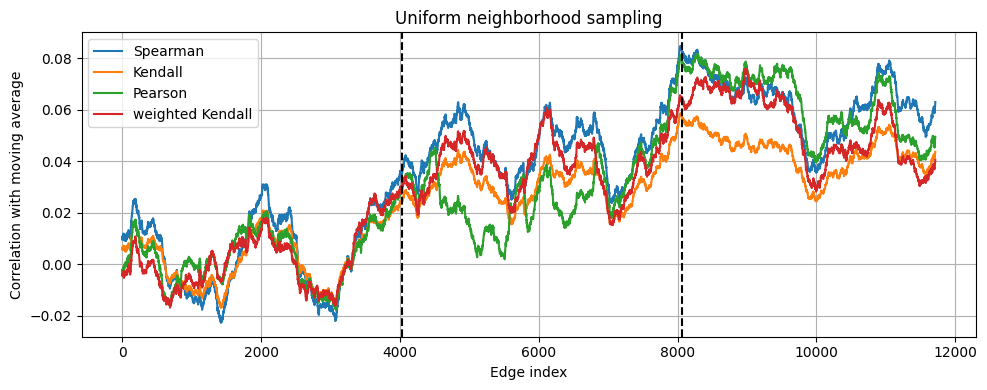

In [90]:
x = range(len(uni_spear))
plt.figure(figsize=(10, 4))
plt.plot(x, uni_spear, label='Spearman')
plt.plot(x, uni_kend, label='Kendall')
plt.plot(x, uni_pearson, label='Pearson')
plt.plot(x,uni_w_kend, label='weighted Kendall')
for i in wiki_midnights:
    plt.axvline(x=i,color='black',linestyle='--')
plt.title('Uniform neighborhood sampling')
plt.xlabel('Edge index')
plt.ylabel('Correlation with moving average')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./saved_figures/uni_samp_wiki")
plt.show()

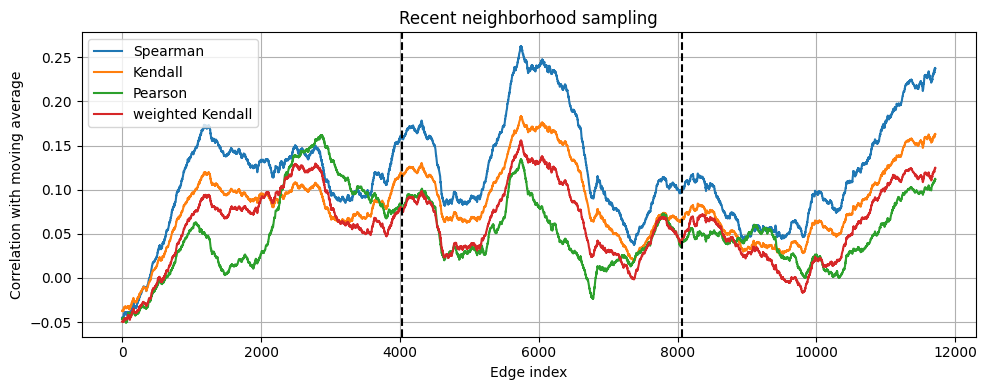

In [91]:
plt.figure(figsize=(10, 4))
plt.plot(x, no_uni_spear, label='Spearman')
plt.plot(x, no_uni_kend, label='Kendall')
plt.plot(x, no_uni_pearson, label='Pearson')
plt.plot(x,no_uni_w_kend, label='weighted Kendall')
for i in wiki_midnights:
    plt.axvline(x=i,color='black',linestyle='--')
plt.title('Recent neighborhood sampling')
plt.xlabel('Edge index')
plt.ylabel('Correlation with moving average')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./saved_figures/recent_samp_wiki")
plt.show()

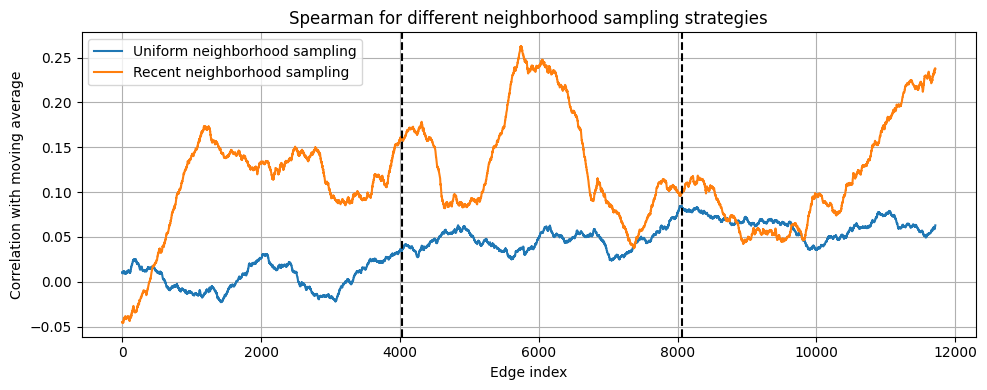

In [92]:
plt.figure(figsize=(10, 4))
plt.plot(x, uni_spear, label='Uniform neighborhood sampling')
plt.plot(x, no_uni_spear, label='Recent neighborhood sampling')
for i in wiki_midnights:
    plt.axvline(x=i,color='black',linestyle='--')
plt.title('Spearman for different neighborhood sampling strategies')
plt.xlabel('Edge index')
plt.ylabel('Correlation with moving average')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./saved_figures/spearman_wiki")
plt.show()

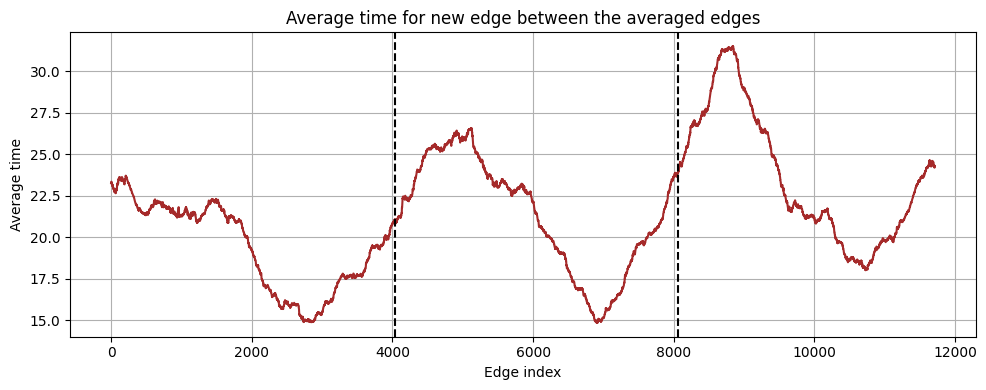

In [93]:
x = range(len(uni_spear))
plt.figure(figsize=(10, 4))
plt.plot(x, wiki_time, color='brown')
for i in wiki_midnights:
    plt.axvline(x=i,color='black',linestyle='--')
plt.title('Average time for new edge between the averaged edges')
plt.xlabel('Edge index')
plt.ylabel('Average time')
plt.grid(True)
plt.tight_layout()
plt.savefig("./saved_figures/time_wiki")
plt.show()


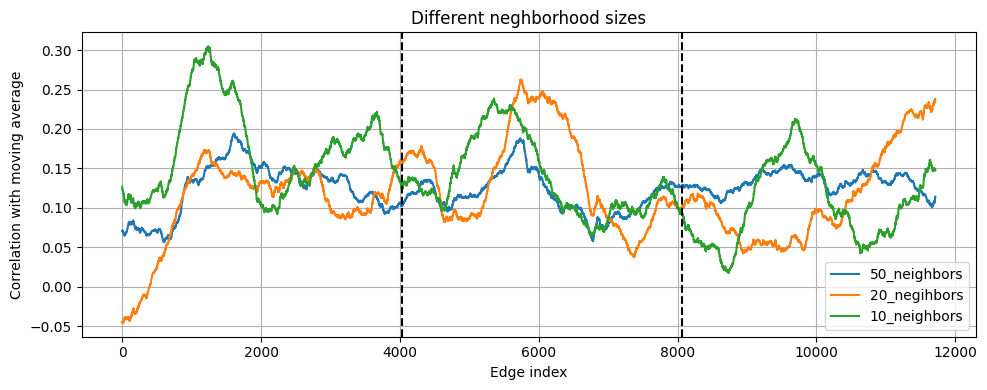

In [94]:
x = range(len(uni_spear))
plt.figure(figsize=(10, 4))
plt.plot(x, no_uni_spear_50nghs, label='50_neighbors')
plt.plot(x, no_uni_spear, label='20_negihbors')
plt.plot(x, no_uni_spear_10nghs, label='10_neighbors')
plt.title('Different neghborhood sizes')
plt.xlabel('Edge index')
plt.ylabel('Correlation with moving average')
for i in wiki_midnights:
    plt.axvline(x=i,color='black',linestyle='--')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./saved_figures/nghs_wiki")
plt.show()

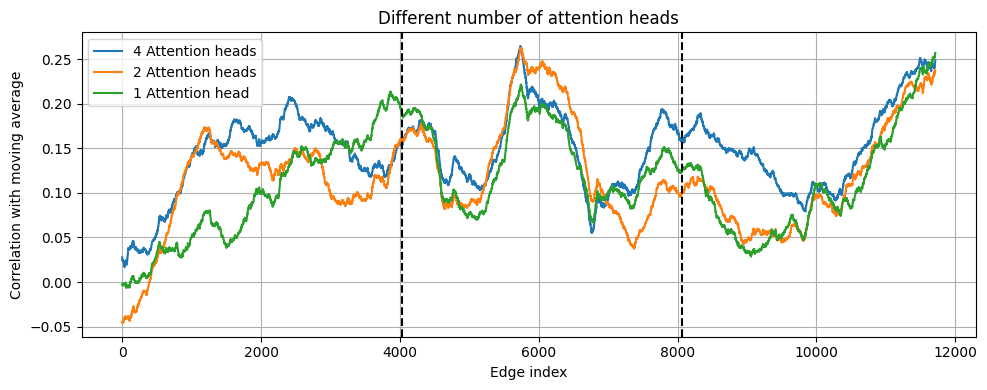

In [95]:
x = range(len(uni_spear))
plt.figure(figsize=(10, 4))
plt.plot(x, no_uni_spear_4head, label='4 Attention heads')
plt.plot(x, no_uni_spear, label='2 Attention heads')
plt.plot(x, no_uni_spear_1head, label='1 Attention head')
plt.title('Different number of attention heads')
plt.xlabel('Edge index')
plt.ylabel('Correlation with moving average')
for i in wiki_midnights:
    plt.axvline(x=i,color='black',linestyle='--')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./saved_figures/attenation_heads_wiki")
plt.show()

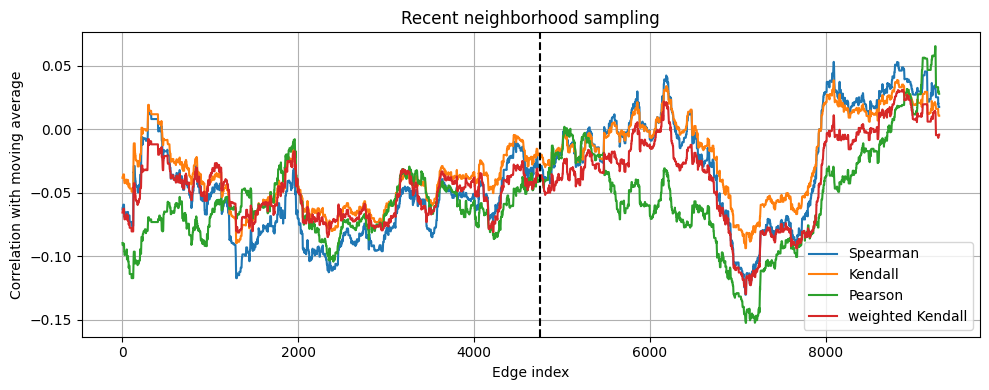

In [96]:
x = range(len(twit_no_uni_spear))
plt.figure(figsize=(10, 4))
plt.plot(x, twit_no_uni_spear, label='Spearman')
plt.plot(x, twit_no_uni_kend, label='Kendall')
plt.plot(x, twit_no_uni_pearson, label='Pearson')
plt.plot(x, twit_no_uni_w_kend, label='weighted Kendall')
for i in twitter_midnights:
    plt.axvline(x=i,color='black',linestyle='--')
plt.title('Recent neighborhood sampling')
plt.xlabel('Edge index')
plt.ylabel('Correlation with moving average')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./saved_figures/no_uni_samp_twit")
plt.show()

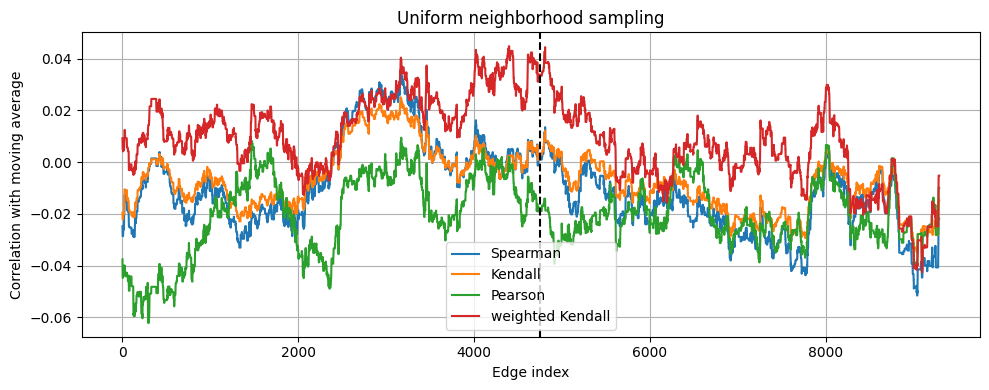

In [97]:
x = range(len(twit_uni_spear))
plt.figure(figsize=(10, 4))
plt.plot(x, twit_uni_spear, label='Spearman')
plt.plot(x, twit_uni_kend, label='Kendall')
plt.plot(x, twit_uni_pearson, label='Pearson')
plt.plot(x, twit_uni_w_kend, label='weighted Kendall')
for i in twitter_midnights:
    plt.axvline(x=i,color='black',linestyle='--')
plt.title('Uniform neighborhood sampling')
plt.xlabel('Edge index')
plt.ylabel('Correlation with moving average')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./saved_figures/uni_samp_twit")
plt.show()


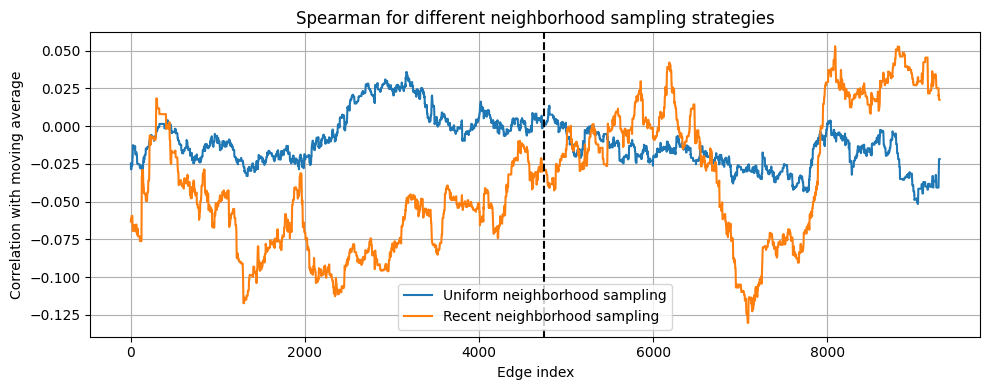

In [119]:
plt.figure(figsize=(10, 4))
plt.plot(x, twit_uni_spear, label='Uniform neighborhood sampling')
plt.plot(x, twit_no_uni_spear, label='Recent neighborhood sampling')
for i in twitter_midnights:
    plt.axvline(x=i,color='black',linestyle='--')
plt.title('Spearman for different neighborhood sampling strategies')
plt.xlabel('Edge index')
plt.ylabel('Correlation with moving average')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./saved_figures/spearman_twitter")
plt.show()

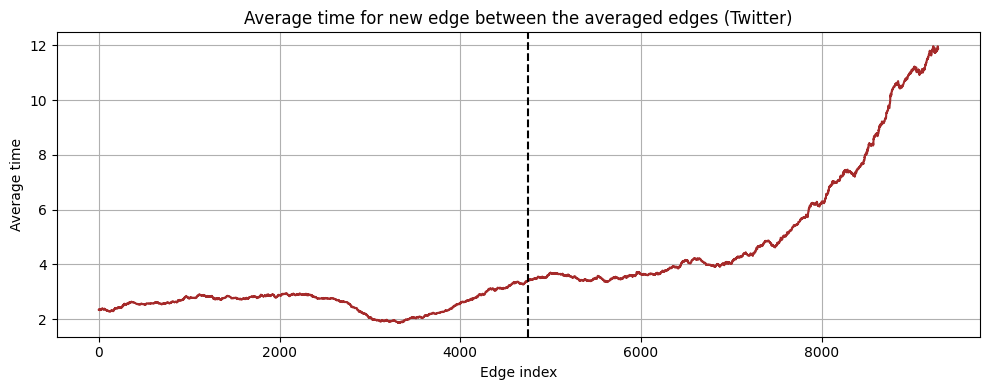

In [98]:
x = range(len(twit_uni_spear))
plt.figure(figsize=(10, 4))
plt.plot(x, twitter_time, color='brown')
for i in twitter_midnights:
    plt.axvline(x=i,color='black',linestyle='--')
plt.title('Average time for new edge between the averaged edges (Twitter)')
plt.xlabel('Edge index')
plt.ylabel('Average time')
plt.grid(True)
plt.tight_layout()
plt.savefig("./saved_figures/time_twitter")
plt.show()

In [71]:
def Apscore(log):
    scores=[]
    with open(log, 'r') as f:
        for line in f:
            if "train ap" in line:
                scores.append(line[line.index("train ap")+10:line.index("train ap")+15])
    return scores

In [100]:
no_uni_wiki_log=Apscore('./log/no_uni_wikifull.log')
uni_wiki_log=Apscore('./log/uni_wikifull.log')
log_1head=Apscore('./log/1_head.log')
log_4head=Apscore('./log/4_head.log')
log_10nghs=Apscore('./log/10_nghs.log')
log_50nghs=Apscore('./log/50nghs.log')

In [196]:
uni_wiki_log

['0.869',
 '0.934',
 '0.951',
 '0.959',
 '0.961',
 '0.964',
 '0.967',
 '0.968',
 '0.969',
 '0.970',
 '0.971',
 '0.973',
 '0.973',
 '0.975',
 '0.974',
 '0.975',
 '0.976',
 '0.977',
 '0.978',
 '0.977']

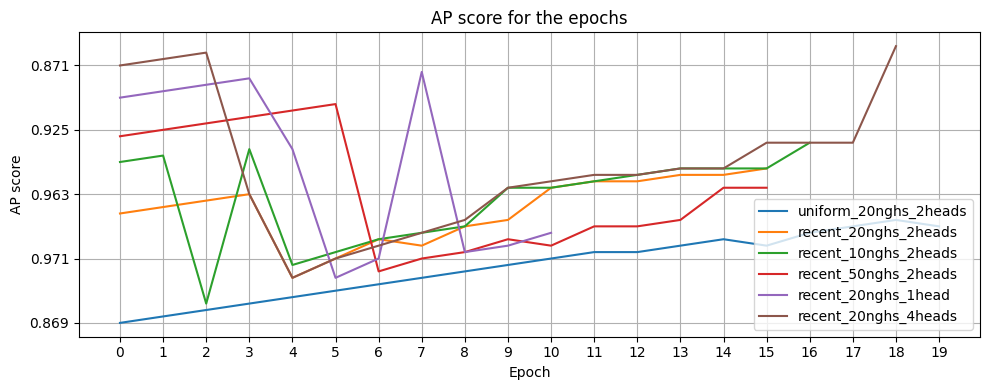

In [111]:

plt.figure(figsize=(10, 4))
plt.plot(range(len(uni_wiki_log)), uni_wiki_log,label='uniform_20nghs_2heads')
plt.plot(range(len(no_uni_wiki_log)), no_uni_wiki_log,label='recent_20nghs_2heads')
plt.plot(range(len(log_50nghs)), log_50nghs,label='recent_10nghs_2heads')
plt.plot(range(len(log_10nghs)), log_10nghs,label='recent_50nghs_2heads')
plt.plot(range(len(log_1head)), log_1head,label='recent_20nghs_1head')
plt.plot(range(len(log_4head)), log_4head,label='recent_20nghs_4heads')
plt.title('AP score for the epochs')
plt.xlabel('Epoch')
plt.ylabel('AP score')
plt.grid(True)
plt.gca().xaxis.set_major_locator(MultipleLocator(1))
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=5))
plt.tight_layout()
plt.legend(loc='lower right')
plt.savefig("./saved_figures/Ap score")
plt.show()